In [2]:
from pymongo import MongoClient
import pandas as pd
import urllib.parse

# Credentials
username = urllib.parse.quote_plus("soundDev")
password = urllib.parse.quote_plus("e1kemyOwhAYXNidM")
cluster_url = "atlas-sql-681e2eb821f0c21b8b5e1712-lkspta.a.query.mongodb.net"

# MongoDB URI
mongo_uri = (
    f"mongodb://{username}:{password}@{cluster_url}/checkoutETL"
    "?ssl=true&authSource=admin"
)

# Connect
client = MongoClient(mongo_uri)
db = client["checkoutETL"]
collection = db["transactions"]

# Relevant columns only
fields_to_pull = {
    "transactionId": 1,
    "campaignName": 1,
    "cardBin": 1,
    "merchant": 1,
    "responseType": 1,
    "txnType": 1,
    "chargebackAmount": 1,
    "totalAmount": 1,
    "_id": 0
}

# Pull filtered data (optionally add a filter/query too)
df = pd.DataFrame(list(collection.find({}, fields_to_pull)))

print(df.head())


   transactionId             campaignName cardBin chargebackAmount  \
0         438514            OptiFuel | AU  521729             None   
1         438526                Ozzi Heat    None             None   
2         438550           MozzGuard - CA  522303             None   
3         438554           MozzGuard - CA  543446             None   
4         438567  Optiwave - US - (Email)  552350             None   

            merchant responseType  totalAmount txnType  
0           ADYEN AU      SUCCESS        29.99    SALE  
1          Paypal US      SUCCESS        29.95    SALE  
2     EMS Josh (NMI)      SUCCESS        89.97    SALE  
3     EMS Josh (NMI)      SUCCESS        89.97    SALE  
4  Payarc Josh (NMI)      SUCCESS        29.95    SALE  


In [5]:
# --- Data prep ---
df["is_auth_success"] = df["responseType"].str.upper() == "SUCCESS"
df["is_refund"] = df["txnType"].str.upper() == "REFUND"
df["chargebackAmount"] = pd.to_numeric(df["chargebackAmount"], errors="coerce")
df["is_chargeback"] = df["chargebackAmount"].fillna(0) > 0


In [7]:
# --- Grouping by Campaign-Gateway-BIN-Merchant ---
grouped = df.groupby(["campaignName", "cardBin", "merchant"]).agg(
    total_txns=("transactionId", "count"),
    auth_successes=("is_auth_success", "sum"),
    refunds=("is_refund", "sum"),
    chargebacks=("is_chargeback", "sum"),
    total_revenue=("totalAmount", "sum"),
    avg_ticket=("totalAmount", "mean")
).reset_index()

In [8]:
# Filter for groups with at least 50 transactions
grouped = grouped[grouped["total_txns"] > 20]

In [9]:
# --- Risk and Rate Calculations ---
grouped["auth_rate"] = grouped["auth_successes"] / grouped["total_txns"]
grouped["refund_rate"] = grouped["refunds"] / grouped["total_txns"]
grouped["chargeback_rate"] = grouped["chargebacks"] / grouped["total_txns"]
grouped["risk_events"] = grouped["refunds"] + grouped["chargebacks"]
grouped["risk_rate"] = grouped["risk_events"] / grouped["total_txns"]
grouped["combined_risk_rate"] = (grouped["refund_rate"] + grouped["chargeback_rate"]) / 2

In [10]:
# --- Percentiles & Scoring ---
grouped["auth_threshold"] = grouped["auth_rate"] >= 0.70
grouped["auth_percentile"] = grouped["auth_rate"].rank(pct=True)
grouped["risk_percentile"] = grouped["combined_risk_rate"].rank(pct=True)
grouped["combined_percentile_score"] = (
    grouped["auth_percentile"] * 0.5 + (1 - grouped["risk_percentile"]) * 0.5
)

In [11]:
# --- Filter Top 10 Campaigns ---
top_10_campaigns = (
    grouped.groupby("campaignName")["total_txns"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_campaign_data = grouped[grouped["campaignName"].isin(top_10_campaigns)]


In [12]:
# --- Get Top 4 Combos for Each Campaign ---
top_combinations = (
    top_campaign_data
    .sort_values(["campaignName", "total_txns"], ascending=[True, False])
    .groupby("campaignName")
    .head(4)
    .reset_index(drop=True)
)

In [14]:
# --- Final columns ---
final_columns = [
    "campaignName", "cardBin", "merchant",
    "total_txns", "auth_successes", "refunds", "chargebacks", "risk_events",
    "total_revenue", "avg_ticket", "auth_rate", "refund_rate", "chargeback_rate", "risk_rate",
    "combined_risk_rate", "auth_threshold", "auth_percentile", "risk_percentile", "combined_percentile_score"
]
final_df = top_combinations[final_columns]

# --- Show Results ---
print(final_df)

                             campaignName cardBin                  merchant  \
0          BTE Hearing CIC Pro (Facebook)  410039             Stripe (Josh)   
1          BTE Hearing CIC Pro (Facebook)  517805             Quantum (NMI)   
2          BTE Hearing CIC Pro (Facebook)  414720             Stripe (Josh)   
3          BTE Hearing CIC Pro (Facebook)  517805             Stripe (Josh)   
4       BTE Hearing CIC Pro (Native) - AU  521729                  ADYEN AU   
5       BTE Hearing CIC Pro (Native) - AU  516361                  ADYEN AU   
6       BTE Hearing CIC Pro (Native) - AU  401795                  ADYEN AU   
7       BTE Hearing CIC Pro (Native) - AU  516323                  ADYEN AU   
8       BTE Hearing CIC Pro (Native) - UK  535666                  Adyen US   
9       BTE Hearing CIC Pro (Native) - UK  537410                  Adyen US   
10      BTE Hearing CIC Pro (Native) - UK  446291                  Adyen US   
11      BTE Hearing CIC Pro (Native) - UK  492915   

In [15]:
final_df

,campaignName,cardBin,merchant,total_txns,auth_successes,refunds,chargebacks,risk_events,total_revenue,avg_ticket,auth_rate,refund_rate,chargeback_rate,risk_rate,combined_risk_rate,auth_threshold,auth_percentile,risk_percentile,combined_percentile_score
0,BTE Hearing CIC Pro (Facebook),410039,Stripe (Josh),103,91,15,0,15,10431.73,101.278932,0.883495,0.145631,0.000000,0.145631,0.072816,True,0.848268,0.795699,0.526284
1,BTE Hearing CIC Pro (Facebook),517805,Quantum (NMI),88,0,0,0,0,3806.67,43.257614,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.013740,0.130227,0.441756
2,BTE Hearing CIC Pro (Facebook),414720,Stripe (Josh),83,26,6,0,6,9938.05,119.735542,0.313253,0.072289,0.000000,0.072289,0.036145,False,0.205496,0.561529,0.321983
3,BTE Hearing CIC Pro (Facebook),517805,Stripe (Josh),81,54,10,0,10,8782.82,108.429877,0.666667,0.123457,0.000000,0.123457,0.061728,False,0.571685,0.732378,0.419654
4,BTE Hearing CIC Pro (Native) - AU,521729,ADYEN AU,146,138,15,0,15,27254.45,186.674315,0.945205,0.102740,0.000000,0.102740,0.051370,True,0.928315,0.677419,0.625448
5,BTE Hearing CIC Pro (Native) - AU,516361,ADYEN AU,110,94,5,1,6,20606.23,187.329364,0.854545,0.045455,0.009091,0.054545,0.027273,True,0.802867,0.497013,0.652927
6,BTE Hearing CIC Pro (Native) - AU,401795,ADYEN AU,103,22,0,0,0,18197.24,176.672233,0.213592,0.000000,0.000000,0.000000,0.000000,False,0.125448,0.130227,0.497611
7,BTE Hearing CIC Pro (Native) - AU,516323,ADYEN AU,87,83,18,0,18,16273.42,187.050805,0.954023,0.206897,0.000000,0.206897,0.103448,True,0.936679,0.905615,0.515532
8,BTE Hearing CIC Pro (Native) - UK,535666,Adyen US,257,62,9,0,9,22690.32,88.289183,0.241245,0.035019,0.000000,0.035019,0.017510,False,0.143369,0.357228,0.393070
9,BTE Hearing CIC Pro (Native) - UK,537410,Adyen US,249,143,4,0,4,22676.42,91.069960,0.574297,0.016064,0.000000,0.016064,0.008032,False,0.475508,0.281959,0.596774


In [17]:
def classify_performance(row, auth_cutoff=0.7, risk_cutoff=0.05):
    # Adjust thresholds as needed; these are examples
    
    low_auth = row["auth_rate"] < auth_cutoff
    high_risk = row["combined_risk_rate"] > risk_cutoff
    
    if low_auth and high_risk:
        return "High Risk"           # Low auth + High refund/chargeback
    elif (not low_auth) and (not high_risk):
        return "Best Performer"     # High auth + Low refund/chargeback
    elif low_auth and high_risk:
        return "Worst Performer"    # Low auth + High refund/chargeback (same as High Risk here)
    else:
        return "Other"

# Apply classification
final_df["performance_category"] = final_df.apply(classify_performance, axis=1)

print(final_df[["campaignName", "cardBin", "merchant", "total_txns", "auth_rate", "combined_risk_rate", "performance_category"]])


                             campaignName cardBin                  merchant  \
0          BTE Hearing CIC Pro (Facebook)  410039             Stripe (Josh)   
1          BTE Hearing CIC Pro (Facebook)  517805             Quantum (NMI)   
2          BTE Hearing CIC Pro (Facebook)  414720             Stripe (Josh)   
3          BTE Hearing CIC Pro (Facebook)  517805             Stripe (Josh)   
4       BTE Hearing CIC Pro (Native) - AU  521729                  ADYEN AU   
5       BTE Hearing CIC Pro (Native) - AU  516361                  ADYEN AU   
6       BTE Hearing CIC Pro (Native) - AU  401795                  ADYEN AU   
7       BTE Hearing CIC Pro (Native) - AU  516323                  ADYEN AU   
8       BTE Hearing CIC Pro (Native) - UK  535666                  Adyen US   
9       BTE Hearing CIC Pro (Native) - UK  537410                  Adyen US   
10      BTE Hearing CIC Pro (Native) - UK  446291                  Adyen US   
11      BTE Hearing CIC Pro (Native) - UK  492915   

C:\Users\shailja tiwari\AppData\Local\Temp\ipykernel_27072\3455953509.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["performance_category"] = final_df.apply(classify_performance, axis=1)


In [18]:
final_df

,campaignName,cardBin,merchant,total_txns,auth_successes,refunds,chargebacks,risk_events,total_revenue,avg_ticket,auth_rate,refund_rate,chargeback_rate,risk_rate,combined_risk_rate,auth_threshold,auth_percentile,risk_percentile,combined_percentile_score,performance_category
0,BTE Hearing CIC Pro (Facebook),410039,Stripe (Josh),103,91,15,0,15,10431.73,101.278932,0.883495,0.145631,0.000000,0.145631,0.072816,True,0.848268,0.795699,0.526284,Other
1,BTE Hearing CIC Pro (Facebook),517805,Quantum (NMI),88,0,0,0,0,3806.67,43.257614,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.013740,0.130227,0.441756,Other
2,BTE Hearing CIC Pro (Facebook),414720,Stripe (Josh),83,26,6,0,6,9938.05,119.735542,0.313253,0.072289,0.000000,0.072289,0.036145,False,0.205496,0.561529,0.321983,Other
3,BTE Hearing CIC Pro (Facebook),517805,Stripe (Josh),81,54,10,0,10,8782.82,108.429877,0.666667,0.123457,0.000000,0.123457,0.061728,False,0.571685,0.732378,0.419654,High Risk
4,BTE Hearing CIC Pro (Native) - AU,521729,ADYEN AU,146,138,15,0,15,27254.45,186.674315,0.945205,0.102740,0.000000,0.102740,0.051370,True,0.928315,0.677419,0.625448,Other
5,BTE Hearing CIC Pro (Native) - AU,516361,ADYEN AU,110,94,5,1,6,20606.23,187.329364,0.854545,0.045455,0.009091,0.054545,0.027273,True,0.802867,0.497013,0.652927,Best Performer
6,BTE Hearing CIC Pro (Native) - AU,401795,ADYEN AU,103,22,0,0,0,18197.24,176.672233,0.213592,0.000000,0.000000,0.000000,0.000000,False,0.125448,0.130227,0.497611,Other
7,BTE Hearing CIC Pro (Native) - AU,516323,ADYEN AU,87,83,18,0,18,16273.42,187.050805,0.954023,0.206897,0.000000,0.206897,0.103448,True,0.936679,0.905615,0.515532,Other
8,BTE Hearing CIC Pro (Native) - UK,535666,Adyen US,257,62,9,0,9,22690.32,88.289183,0.241245,0.035019,0.000000,0.035019,0.017510,False,0.143369,0.357228,0.393070,Other
9,BTE Hearing CIC Pro (Native) - UK,537410,Adyen US,249,143,4,0,4,22676.42,91.069960,0.574297,0.016064,0.000000,0.016064,0.008032,False,0.475508,0.281959,0.596774,Other


In [19]:
final_df.to_excel("top_campaign_risk_matrix.xlsx", index=False)

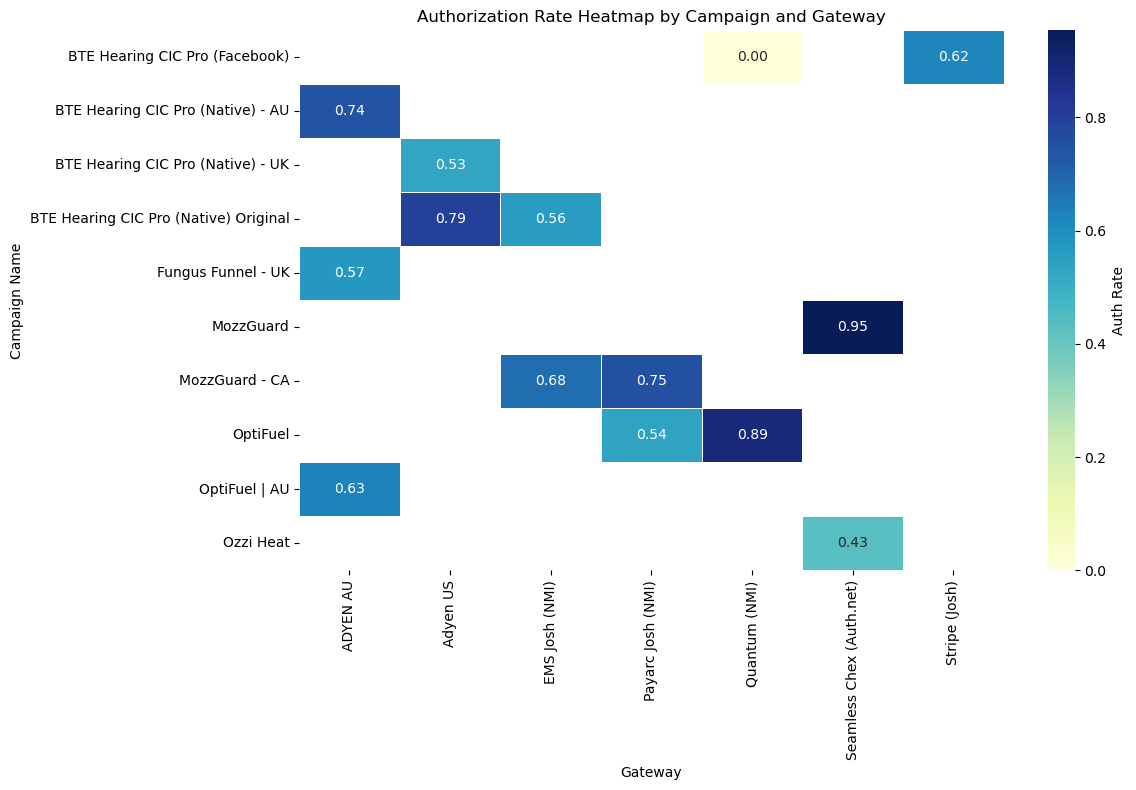

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example: Pivot table with campaignName as rows, gateway as columns, values = auth_rate
heatmap_data = final_df.pivot_table(
    index='campaignName',
    columns='merchant',
    values='auth_rate',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,        # show values
    fmt=".2f",
    cmap="YlGnBu",     # color map (green to blue)
    linewidths=0.5,
    cbar_kws={'label': 'Auth Rate'}
)
plt.title('Authorization Rate Heatmap by Campaign and Gateway')
plt.ylabel('Campaign Name')
plt.xlabel('Gateway')
plt.tight_layout()
plt.show()


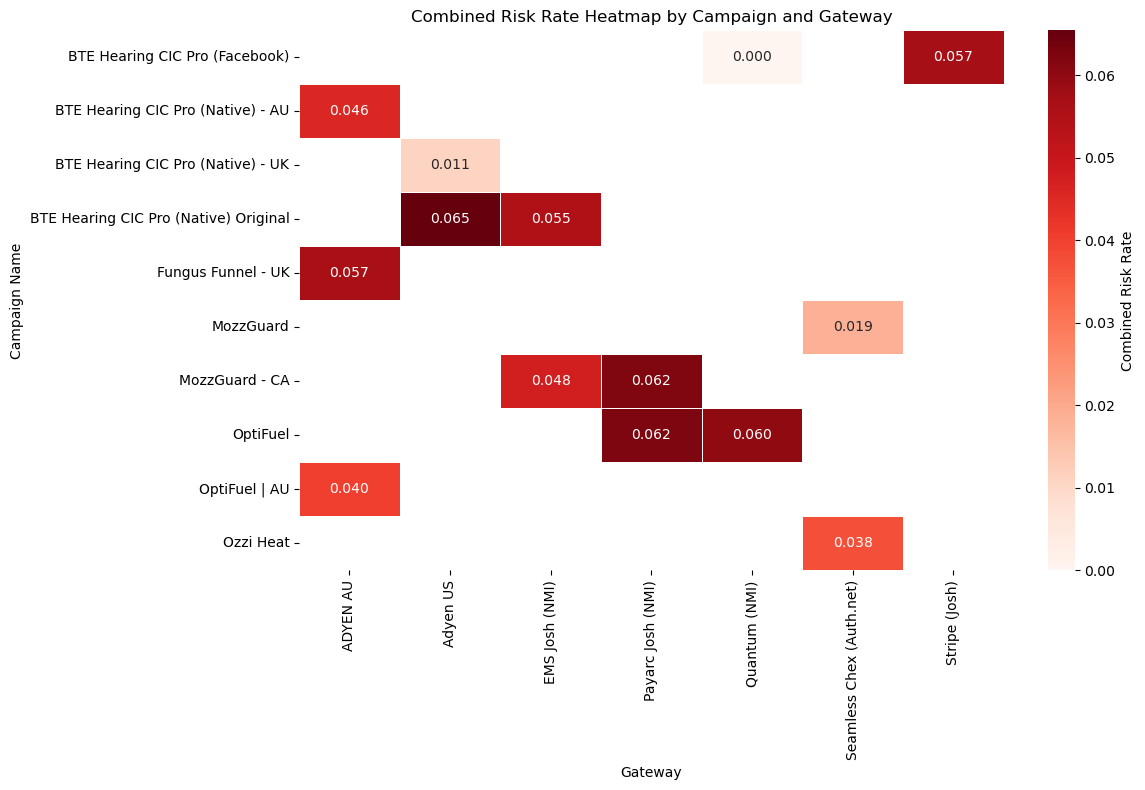

In [22]:
heatmap_data = final_df.pivot_table(
    index='campaignName',
    columns='merchant',
    values='combined_risk_rate',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="Reds",   # Reds color map for risk
    linewidths=0.5,
    cbar_kws={'label': 'Combined Risk Rate'}
)
plt.title('Combined Risk Rate Heatmap by Campaign and Gateway')
plt.ylabel('Campaign Name')
plt.xlabel('Gateway')
plt.tight_layout()
plt.show()
